In [1]:
# Importing PlaidML. Make sure you follow this 
import os
try:
    import plaidml.keras
    plaidml.keras.install_backend()
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    from keras import backend as K
    # example of training a gan on mnist
    import keras
    from keras.optimizers import Adam
    from keras import Sequential
    from keras import layers
    from keras.layers import Dense
    from keras.layers import Reshape
    from keras.layers import Flatten
    from keras.layers import Conv2D
    from keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from keras.layers import LeakyReLU
    from keras.layers import Dropout
    from keras.models import load_model
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint
    #------------------------------
    print("Running on MAC OS")
except:
    from tensorflow.keras.optimizers import Adam
    from tensorflow import keras
    from tensorflow.keras import Sequential
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Reshape
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from tensorflow.keras.layers import LeakyReLU
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.models import load_model
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    print("Running on Server/PC")
    #------------------------------------------


import os
from os.path import exists as file_exists    

# Libraries
import glob
import csv
import json
import math
import joblib
#------------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import visualkeras

# Metric
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
#------------------------------

import scipy
from scipy.cluster import hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
#--------------------------------------------


Running on MAC OS


In [2]:
#--------------- Create Folders -------------
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory created!\n{directory}")
def find_r_from_z (data):
    return np.tanh(data)

def find_z_from_r (data):
    return np.arctanh(data)

def rename_sigids(dataframe):
    new_list = {}
    try:
        list_of_sigs = list(dataframe.columns)
        dtype = 'df'
    except:
        list_of_sigs = list(dataframe).copy()
        dtype = 'list'
        
    for sig in list_of_sigs:
        sigs = sig.split("_")
        if len(sigs) != 5:
            new_list[sig] = sig
        else:  
            sig_no = sigs[1]
            id_no = sigs[-1]
            if dataset == 'syncan':
                new_list[sig] = f"S:{sig_no.zfill(1)}_ID:{id_no.zfill(2)}"
            else:
                new_list[sig] = f"S:{sig_no.zfill(1)}_ID:{id_no.zfill(4)}"

            
    if dtype == 'list':
        return list(new_list.values())
    else:
        dataframe = dataframe.rename(columns=new_list)
        dataframe = dataframe.rename(index=new_list)
        return dataframe

In [6]:

# %%
# Creating two lists of ambient and attack datasets
cur_dir= os.getcwd()
dataset = 'syncan'
# dataset = 'road'


ambient_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//ambients//*.csv")
attack_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//attacks//*.csv")

# Creating two lists of file names 
ambient_files = [x.split("/")[-1].split(".")[0][0:-10] for x in ambient_dirs]
attack_files = [x.split("/")[-1].split(".")[0][0:-10] for x in attack_dirs]

print(f"Ambient files are:\n {ambient_files[0:]}, etc.")
print(f"\n\nAttack files are:\n {attack_files[0:]}, etc.")

# %%
# ambient_files

# %%
# Defining parameters...........

Ambient files are:
 ['train_3', 'train_4', 'train_1', 'train_2'], etc.


Attack files are:
 ['test_plateau', 'test_suppress', 'test_continuous', 'test_flooding', 'test_playback'], etc.


In [7]:
ambient_files =ambient_files[2:]
ambient_files

['train_1', 'train_2']

train_1
Loading dataset:  train_1


KeyboardInterrupt: 

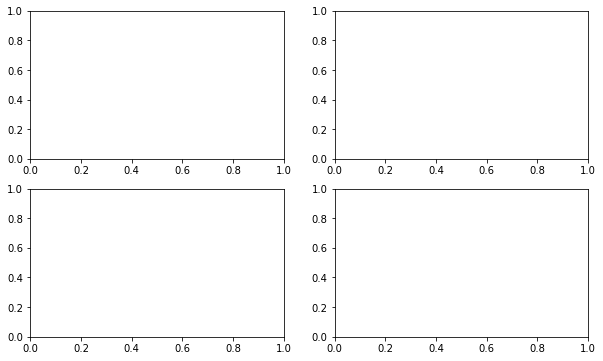

In [8]:
try:
    del corr_df_mean, corr_df_max, z_fisher
except:
    pass


# reading each dataset in a df file
folder_name_data = "Saved_Data"
folder_name_plots = "overall"

ensure_dir(f"{folder_name_data}//")
ensure_dir(f"plots//{folder_name_plots}//")

if dataset == 'syncan':
    fig, axes = plt.subplots(2, 2, figsize = (10,6))
else:
    fig, axes = plt.subplots(3, 4, figsize = (16,8))
    
axs = axes.flatten()
df_scale = pd.DataFrame([])

for indx, (file_name, file_dir) in enumerate(zip(ambient_files, ambient_dirs)):
    ax = axs[indx]
#     if file_name !=  'ambient_dyno_drive_basic_short':
#         continue
        
    print(file_name)

    try:
        #Try loading corr mat.............
#         regenerate
        corr_df_new = abs(pd.read_csv(f"{folder_name_data}//Corr_matrix_update_{file_name}.csv" ,index_col=0).fillna(0))
        print(f"Loaded {file_name}")
        
    except:
        #Generate corr mat and store......
        print("Loading dataset: ",file_name)
        # Checking if the signalwise data already exists
        X_train = pd.read_csv(file_dir, index_col = 0) 

        # Defining the number of signals..............................
        X_train = X_train.copy()
        X_train = X_train.drop(columns = ['Label', 'Time', 'ID']).copy()

        if dataset == 'road':
            # Forward filling algorithm........
            print("Forward filling...")
            X_train = X_train.ffill().copy()
            X_train = X_train.bfill().dropna()   
            #--------------------------------
            print("X_train.shape", X_train.shape)
            #------------------------------------
        else:
            print("No treatment needed for SynCAN!")
        
        # Loading data..........................
        # X_train = X_train.values
        
        #Saving scaler data.........................................
        scaler_train = MinMaxScaler()
        scaler_train.fit(X_train.values)
        df_scale[f'{file_name}_max'] = list(scaler_train.data_max_)
        df_scale[f'{file_name}_min'] = list(scaler_train.data_min_)
        #............................................................

        #Correlation matrix..........................................
        corr_df_new = X_train[0::100].corr().fillna(0).copy()
        #Saving corr mat.......................
        corr_df_new.to_csv(f"{folder_name_data}//Corr_matrix_update_{file_name}.csv", index = True, header = True)
        #Corr mat is loaded...........................................

    try:
#         print(" Updating pixels..... 1")
        corr_df_mean += corr_df_new
        col_list = corr_df_new.columns.to_list()
        indeces = corr_df_new.loc[col_list,col_list] > corr_df_max.loc[col_list,col_list] 
        corr_df_max[indeces] = corr_df_new[indeces].copy()
#         corr_df_max[corr_df_new > corr_df_max] = corr_df_new[corr_df_new > corr_df_max].copy()
        z_fisher += find_z_from_r(corr_df_new.values)
        
    except Exception as e:
        print('Failed to upload to ftp: '+ str(e))
        print("*********** Adding new Corr *************")
        columns_list = corr_df_new.columns.tolist()
        corr_df_mean = corr_df_new.copy()
        corr_df_max = corr_df_new.copy()
        z_fisher = find_z_from_r(corr_df_new.values)
        
    ax = sns.heatmap(corr_df_new, ax = ax, xticklabels=False, yticklabels=False)
    ax.set_title(file_name)
#     ax.tick_params(left=False, bottom=False) ## other options are right and top
fig.suptitle("Correlation heatmaps of different files")
plt.tight_layout()
plt.savefig(f"plots//{folder_name_plots}//Corr_Heatmaps_{dataset}.jpg", dpi = 350) 
plt.show()

# Finalizing the corr mats.......................
corr_df_mean = (corr_df_mean/len(ambient_files)).fillna(0)
z_fisher = z_fisher/len(ambient_files)
corr_df_fisher = pd.DataFrame(find_r_from_z(z_fisher)).fillna(0)
corr_df_fisher.columns = corr_df_mean.columns
corr_df_fisher.index = corr_df_mean.index

try:
    df_scale.index = X_train.columns
    df_scale = df_scale.T.copy()
    df_scale.to_csv(f"Scalling_Data/min_max_values_{dataset}.csv", header=True, index=True)
    #.................................................
except:
    pass

In [9]:
corr_df_new = abs(pd.read_csv(f"{folder_name_data}//Corr_matrix_update_{file_name}.csv" ,index_col=0).fillna(0))
print(f"Loaded {file_name}")

FileNotFoundError: [Errno 2] No such file or directory: 'Saved_Data//Corr_matrix_update_train_1.csv'

In [ ]:
# fig, axes = plt.subplots(4,5, figsize = (12, 4.5), sharex = True)
# for sig, ax in zip(top_signals, axes.flatten()):
#     X_train[sig][0:1000000].plot(ax = ax, marker = 'p', linestyle = '--', markersize= '0.5')
#     ax.set_title(sig)
#     ax.set_xlabel("Time Step")
# fig.suptitle("Time series plot of different signals")
# plt.tight_layout()
# plt.savefig(f"plots//{folder_name_plots}//Time_series_{dataset}.jpg", dpi = 350) 
# plt.savefig(f"plots//{folder_name_plots}//Time_series_{dataset}.pdf") 

# plt.show()

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(corr_df_mean, vmin = 0, vmax = 1 )
# fig.suptitle("Correlation heatmaps of different files")
plt.title("Overall correltion heatmap: Mean")
plt.tight_layout()
plt.savefig(f"plots//{folder_name_plots}//Corr_Heatmap_Overall_{dataset}_Mean.jpg", dpi = 350) 
plt.show()

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(corr_df_fisher, vmin = 0, vmax = 1 )
# fig.suptitle("Correlation heatmaps of different files")
plt.title("Overall correltion heatmap: Z Fischer")
plt.tight_layout()
plt.savefig(f"plots//{folder_name_plots}//Corr_Heatmap_Overall_{dataset}_Fischer.jpg", dpi = 350) 
plt.show()

In [ ]:
num_of_Signals = 50

In [ ]:
if dataset == 'syncan':
    top_signals = list(corr_df_fisher.columns)
else:
    # Opening attacked signals file
    #-----------------------
    f = open(cur_dir+f"//Saved_Data//attacked_signals.json")
    attacked_signals = json.load(f)
    f.close()
    x = [] 
    for val in attacked_signals.values(): x +=val
    targeted_signals = list(set(x))

    # Top 20 signals........................
    top_signals_df = pd.DataFrame([])

    for targeted_signal in targeted_signals:
        top_signals_df[targeted_signal] = corr_df_fisher[targeted_signal].sort_values(ascending=False).index

    # ......................
    top_signals = targeted_signals.copy()
    row = 0
    col = 0

    while(len(top_signals) < num_of_Signals):

        sig = top_signals_df.iloc[row, col]
        #print(f"{row}, {col} : {sig}")
        if sig not in top_signals:
            top_signals.append(sig)
    #         print(f"Adding {sig}")
        col += 1  

        if col == len(targeted_signals):
            #print("going to the next row...")
            col = 0
            row += 1      
    #     print(len(top_signals))


In [ ]:
top_signals

In [ ]:
#--------------------------------------------
from scipy.cluster import hierarchy as sch
from scipy.cluster.hierarchy import dendrogram

fig, axes = plt.subplots(1, 3, figsize = (17, 5))

#------------ Clustering again ---------------
# Plotting the correlation matrix...........

# corr_df_target = corr_df_fisher.copy()

corr_df_target = corr_df_mean.copy()


top_signals = rename_sigids(top_signals)
corr_df_target = rename_sigids(corr_df_target)

corr_df = abs(corr_df_target.loc[top_signals,top_signals]).copy()


sns.heatmap(corr_df, ax = axes[0]) # unclustered version
# plt.savefig(f"plots/heatmap_before_{file_name}.jpg", dpi = 500)
# plt.show()
axes[0].set_title("Correlation before clustering")

#--------------------------------------------
corr_array = corr_df.copy()
inplace = False
pairwise_distances = sch.distance.pdist(corr_array)
linkage = sch.linkage(pairwise_distances, method='complete')

#--------------------------------------------
# plt.figure(figsize=(5, 5)) 
axes[1].set_title("Dendrograms of hierarchical clustering")
dend = sch.dendrogram(linkage, orientation='right', labels=corr_df.index, ax =axes[1])
#--------------------------------------------
# Plotting the correlation matrix...........
sns.heatmap(corr_df.loc[dend['ivl'][::-1], dend['ivl'][::-1]], ax = axes[2])
axes[2].set_title("Correlation after clustering")

if dataset == 'syncan':
    fig.suptitle(f"Signal clustering and rearranging based on correlations: SynCAN dataset")
else:
    fig.suptitle(f"Signal clustering and rearranging based on correlations: ROAD dataset")

plt.tight_layout()
plt.savefig(f"plots//{folder_name_plots}//heatmap_before_after_den_{dataset}.jpg", dpi = 500)
plt.show()

#Updating the columns sequence
#--------------------------------------------
# print(dend['ivl'][::-1])

In [ ]:
# # Top 50

# list_of_sigs = dend['ivl'][::-1]
# list_of_sigs
# ['S:4_ID:0167',
#  'S:2_ID:1505',
#  'S:4_ID:1031',
#  'S:1_ID:0051',
#  'S:4_ID:0778',
#  'S:8_ID:0778',
#  'S:4_ID:1628',
#  'S:2_ID:1255',
#  'S:2_ID:0526',
#  'S:1_ID:1760',
#  'S:4_ID:1176',
#  'S:6_ID:0208',
#  'S:3_ID:1760',
#  'S:4_ID:1760',
#  'S:2_ID:1760',
#  'S:1_ID:0167',
#  'S:7_ID:0208',
#  'S:5_ID:1590',
#  'S:7_ID:1628',
#  'S:9_ID:1413',
#  'S:9_ID:0167',
#  'S:8_ID:1455',
#  'S:5_ID:0640',
#  'S:2_ID:0852',
#  'S:3_ID:0622',
#  'S:2_ID:1398',
#  'S:9_ID:1455',
#  'S:3_ID:1076',
#  'S:11_ID:1031',
#  'S:10_ID:0470',
#  'S:1_ID:0683',
#  'S:2_ID:0778',
#  'S:6_ID:0628',
#  'S:6_ID:0167',
#  'S:3_ID:0208',
#  'S:1_ID:0852',
#  'S:7_ID:1788',
#  'S:2_ID:0051',
#  'S:7_ID:0354',
#  'S:3_ID:0996',
#  'S:1_ID:1634',
#  'S:2_ID:0208',
#  'S:1_ID:0014',
#  'S:3_ID:0014',
#  'S:8_ID:0470',
#  'S:2_ID:0061',
#  'S:2_ID:0204',
#  'S:3_ID:0458',
#  'S:5_ID:1372',
#  'S:5_ID:0631']

In [ ]:
# Top 10

# list_of_sigs = dend['ivl'][::-1]
# list_of_sigs
# ['S:4_ID:1628',
#  'S:2_ID:1255',
#  'S:3_ID:1760',
#  'S:6_ID:0208',
#  'S:1_ID:1760',
#  'S:4_ID:1760',
#  'S:2_ID:1760',
#  'S:5_ID:1590',
#  'S:3_ID:0208',
#  'S:3_ID:0014']

In [ ]:
# #Top 5
# # list_of_sigs = dend['ivl'][::-1]
# # list_of_sigs
# ['S:3_ID:1760',
#  'S:6_ID:0208',
#  'S:1_ID:1760',
#  'S:4_ID:1760',
#  'S:2_ID:1760',
#  'S:2_ID:1255',
#  'S:3_ID:0208']